In [1]:
import gym
import pybullet_envs
import random
import numpy as np
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import time
from gym.envs.registration import register
from IPython.display import clear_output
from itertools import count

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
env = gym.make('HumanoidBulletEnv-v0')
print('observation_space:', env.observation_space.shape)
print('action_space:', env.action_space.shape)

observation_space: (44,)
action_space: (17,)


/home/tom/venv/lib/python3.5/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
print(env.action_space.high, env.action_space.low)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [5]:
from collections import deque

class Memory:
    def __init__(self, maxlen=1000000):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, item):
        self.buffer.append(item)
       
    def replay(self, size):
        samples = random.sample(self.buffer, size)
        def atleast_2d(a): # ensure at least shape (size, 1) instead of (size,)
            return np.expand_dims(a, axis=1) if a.ndim < 2 else a
        samples = [atleast_2d(np.asarray(sample, dtype=np.float64)) for sample in zip(*samples)]
        
        return samples

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, concatenate

class Actor:
    def __init__(self, state_dim, action_dim, action_low, action_high):
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        
        inputs = Input((state_dim,))
        hidden = Dense(128, activation='relu')(inputs)
        hidden = Dense(128, activation='relu')(hidden)
        outputs = Dense(action_dim, activation='tanh', kernel_initializer=last_init)(hidden)
        def rescale(x):
            return x * action_high
        outputs = Lambda(rescale)(outputs)
        
        self.model = Model(inputs, outputs)
        
        self.action_low = action_low
        self.action_high = action_high
        
        self.mu = 0.0
        self.sigma = 0.1
        
    def select(self, state, add_noise=True):
        states = np.expand_dims(state, axis=0)
        action = self.model(states)
        if add_noise:
            action += np.random.normal(self.mu, self.sigma, size=action.shape)
            
        action = np.clip(action, self.action_low, self.action_high)
        return action

In [7]:
class Critic:
    def __init__(self, state_dim, action_dim):
        state_in = Input((state_dim,))
        action_in = Input((action_dim,))
        concat = concatenate([state_in, action_in])
        hidden = Dense(128, activation='relu')(concat)
        hidden = Dense(128, activation='relu')(hidden)
        output = Dense(1, activation='linear')(hidden)
        
        self.model = Model([state_in, action_in], output)

In [8]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [9]:
class Agent:
    def __init__(self, env):
        state_dim = np.squeeze(env.observation_space.shape)
        action_dim = np.squeeze(env.action_space.shape)
        
        self.state_dim, self.action_dim = state_dim, action_dim
        
        action_high = env.action_space.high
        action_low = env.action_space.low
        
        '''Initialize critic networks Qθ1, Qθ2, 
        and actor network πφ with random parameters θ1, θ2, φ'''
        self.critic_1 = Critic(state_dim, action_dim)
        self.critic_2 = Critic(state_dim, action_dim)
        self.actor = Actor(state_dim, action_dim, action_low, action_high)
        
        '''Initialize target networks θ1' ← θ1, θ2' ← θ2, φ' ← φ'''
        self.target_critic_1 = Critic(state_dim, action_dim)
        self.target_critic_1.model.set_weights(self.critic_1.model.get_weights())
        
        self.target_critic_2 = Critic(state_dim, action_dim)
        self.target_critic_2.model.set_weights(self.critic_2.model.get_weights())
        
        self.target_actor = Actor(state_dim, action_dim, action_low, action_high)
        self.target_actor.model.set_weights(self.actor.model.get_weights())
        
        '''Initialize replay buffer B'''
        self.memory = Memory(1000000)
        self.batch_size = 64
        
        self.policy_noise = 0.2
        self.noise_clip = 0.5
        
        self.total_epochs = 0
        self.policy_update = 2
        
        self.gamma = 0.99
        
        self.actor_optimizer = tf.keras.optimizers.Adam(lr=0.0003)
        self.critic_optimizer = tf.keras.optimizers.Adam(lr=0.0003)
        
        self.tau = 0.005
    
    @tf.function
    def update_actor(self, states):
        '''Update φ by the deterministic policy gradient:
            ∇φJ(φ) = N −1 P∇aQθ1(s, a)|a=πφ(s)∇φπφ(s)'''
        with tf.GradientTape() as tape:
            actions = self.actor.model(states)
            actor_loss = -tf.reduce_mean(self.critic_1.model([states, actions]))
            # minus sign to maximize critic value --> max(Q[i])
        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.model.trainable_variables))

    @tf.function
    def train(self, states, actions, rewards, next_states, not_dones):
        '''e ∼ clip(N (0, σ˜), −c, c)'''
        noise = tf.random.normal(actions.shape, 0, self.policy_noise, tf.float64)
        noise = tf.clip_by_value(noise, -self.noise_clip, self.noise_clip)

        '''a˜ ← πφ0 (s') + e'''
        next_action = self.target_actor.model(next_states)
        next_action = tf.clip_by_value(
            next_action + noise, 
            self.actor.action_low, 
            self.actor.action_high
        )

        '''y ← r + γ mini=1,2 Qθ(',i)(s', a˜)'''
        target_Q_1 = self.target_critic_1.model([next_states, next_action])
        target_Q_2 = self.target_critic_2.model([next_states, next_action])
        target_Q = rewards + self.gamma * tf.minimum(target_Q_1, target_Q_2) * not_dones
        
        '''Update critics θi ← argminθi N −1 P(y−Qθi(s, a))2'''
        with tf.GradientTape() as tape:
            Q_1 = self.critic_1.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q_1))
        grad = tape.gradient(loss, self.critic_1.model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grad, self.critic_1.model.trainable_variables))

        with tf.GradientTape() as tape:
            Q_2 = self.critic_2.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q_2))
        grad = tape.gradient(loss, self.critic_2.model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grad, self.critic_2.model.trainable_variables))
        
agent = Agent(env)

In [10]:
def run(agent, max_episode=100):
    history = []
    for ep in range(max_episode):
        state = env.reset()
        ep_reward = 0
        
        '''for t = 1 to T do'''
        for step in count():
            '''Select action with exploration noise a ∼ πφ(s) + e, e ∼ N (0, σ)'''
            action = agent.actor.select(state)[0]
            
            '''and observe reward r and new state s'''
            next_state, reward, done, _ = env.step(action)
            
            '''Store transition tuple (s, a, r, s') in B'''
            agent.memory.add((state, action, reward, next_state, 1 - done))

            if len(agent.memory.buffer) >= agent.batch_size:
                agent.total_epochs += 1
                samples = agent.memory.replay(agent.batch_size)

                '''Sample mini-batch of N transitions (s, a, r, s') from B'''
                states, actions, rewards, next_states, not_dones = samples
                agent.train(states, actions, rewards, next_states, not_dones)

                '''if t mod d then'''
                if agent.total_epochs % agent.policy_update == 0:
                    agent.update_actor(states)

                    '''Update target networks:'''
                    '''θ'i ← τθi + (1 − τ )θ'i
                    φ' ← τφ + (1 − τ )φ`'''
                    update_target(agent.target_critic_1.model.variables, agent.critic_1.model.variables, agent.tau)
                    update_target(agent.target_critic_2.model.variables, agent.critic_2.model.variables, agent.tau)
                    update_target(agent.target_actor.model.variables, agent.actor.model.variables, agent.tau)

            ep_reward += reward
            
            if done:
                break
            state = next_state
            
        history.append(ep_reward)
        print('Episode: {}, ep_reward: {}, step: {}'.format(ep, ep_reward, step + 1))
    
    return history

In [11]:
history = run(agent, 10000)

Episode: 0, ep_reward: 33.50639432851534, step: 22
Episode: 1, ep_reward: 33.930364529523814, step: 21
Episode: 2, ep_reward: 27.156653723625755, step: 19
Episode: 3, ep_reward: 31.90577264349384, step: 20
Episode: 4, ep_reward: 24.689886419440402, step: 18
Episode: 5, ep_reward: 12.230790319021883, step: 17
Episode: 6, ep_reward: 1.3849017370458916, step: 17
Episode: 7, ep_reward: -18.97220390781905, step: 17
Episode: 8, ep_reward: -27.419147195756253, step: 16
Episode: 9, ep_reward: -16.061131277881202, step: 16
Episode: 10, ep_reward: -9.090428741879608, step: 15
Episode: 11, ep_reward: 18.891841326131665, step: 18
Episode: 12, ep_reward: 30.77560838047711, step: 23
Episode: 13, ep_reward: 26.15050309473619, step: 25
Episode: 14, ep_reward: 28.72392193304285, step: 28
Episode: 15, ep_reward: 28.056799243658286, step: 30
Episode: 16, ep_reward: 4.425345689872879, step: 27
Episode: 17, ep_reward: 13.659146863999633, step: 54
Episode: 18, ep_reward: 6.694270240118261, step: 20
Episode:

Episode: 155, ep_reward: 3.662753554768374, step: 18
Episode: 156, ep_reward: -5.484834654797725, step: 19
Episode: 157, ep_reward: 4.022833575298906, step: 22
Episode: 158, ep_reward: 4.251390211661059, step: 18
Episode: 159, ep_reward: 10.238754406611221, step: 18
Episode: 160, ep_reward: 10.182628307293637, step: 18
Episode: 161, ep_reward: 13.233325221221525, step: 19
Episode: 162, ep_reward: 10.476230537952802, step: 19
Episode: 163, ep_reward: 7.502865226532278, step: 18
Episode: 164, ep_reward: 10.302973142884403, step: 18
Episode: 165, ep_reward: -20.56217369938029, step: 18
Episode: 166, ep_reward: 8.026273561235769, step: 18
Episode: 167, ep_reward: 12.258299307236431, step: 18
Episode: 168, ep_reward: 2.4194179205532915, step: 18
Episode: 169, ep_reward: 8.182158934799947, step: 19
Episode: 170, ep_reward: 9.189351673863706, step: 19
Episode: 171, ep_reward: 9.859024272825149, step: 19
Episode: 172, ep_reward: 5.351192398640022, step: 19
Episode: 173, ep_reward: 8.0148824425

Episode: 309, ep_reward: 20.559232916643754, step: 28
Episode: 310, ep_reward: 23.010394762345218, step: 28
Episode: 311, ep_reward: 25.26967296539359, step: 26
Episode: 312, ep_reward: -3.1396266730612488, step: 17
Episode: 313, ep_reward: 26.671451805334556, step: 26
Episode: 314, ep_reward: 22.524931988160837, step: 27
Episode: 315, ep_reward: 35.526849852985926, step: 29
Episode: 316, ep_reward: 26.173891855105992, step: 31
Episode: 317, ep_reward: 48.44009384570432, step: 39
Episode: 318, ep_reward: 48.11214951798017, step: 37
Episode: 319, ep_reward: 16.517886557212286, step: 28
Episode: 320, ep_reward: 19.50378880282554, step: 21
Episode: 321, ep_reward: 9.380911537345266, step: 21
Episode: 322, ep_reward: 28.49834542285022, step: 43
Episode: 323, ep_reward: -7.660325466652985, step: 19
Episode: 324, ep_reward: 62.37372166387357, step: 52
Episode: 325, ep_reward: 15.310763920585426, step: 26
Episode: 326, ep_reward: -1.3232279316212847, step: 21
Episode: 327, ep_reward: -0.32278

Episode: 463, ep_reward: 62.554901605283874, step: 45
Episode: 464, ep_reward: 29.71387790606125, step: 30
Episode: 465, ep_reward: 83.79877215297073, step: 52
Episode: 466, ep_reward: 22.20457598288846, step: 27
Episode: 467, ep_reward: 44.926313683855824, step: 44
Episode: 468, ep_reward: 87.29713212323064, step: 70
Episode: 469, ep_reward: 57.938416992291, step: 42
Episode: 470, ep_reward: 21.851736067589613, step: 30
Episode: 471, ep_reward: 20.837815140214744, step: 48
Episode: 472, ep_reward: 60.53998819935239, step: 63
Episode: 473, ep_reward: 24.993353327922737, step: 41
Episode: 474, ep_reward: 11.11854118325389, step: 21
Episode: 475, ep_reward: 30.388331044396693, step: 33
Episode: 476, ep_reward: 86.61130307346792, step: 58
Episode: 477, ep_reward: 7.64335411849031, step: 44
Episode: 478, ep_reward: 44.449151806916255, step: 44
Episode: 479, ep_reward: 61.06467212922698, step: 51
Episode: 480, ep_reward: 96.01594562512287, step: 85
Episode: 481, ep_reward: 40.66250859548882

Episode: 617, ep_reward: 63.626517013998225, step: 42
Episode: 618, ep_reward: 87.40936546384434, step: 85
Episode: 619, ep_reward: 17.70531852035867, step: 70
Episode: 620, ep_reward: 66.93111280046985, step: 51
Episode: 621, ep_reward: 105.41409543090963, step: 74
Episode: 622, ep_reward: 37.766470825601935, step: 75
Episode: 623, ep_reward: 34.69021108634553, step: 70
Episode: 624, ep_reward: 63.21850414296227, step: 47
Episode: 625, ep_reward: 62.221995465527996, step: 53
Episode: 626, ep_reward: 54.255645947421115, step: 41
Episode: 627, ep_reward: 82.12781249073274, step: 74
Episode: 628, ep_reward: 73.70109292417565, step: 50
Episode: 629, ep_reward: 65.44018316220944, step: 45
Episode: 630, ep_reward: 73.00321938361539, step: 54
Episode: 631, ep_reward: -11.365644750600001, step: 17
Episode: 632, ep_reward: -8.462658407848428, step: 22
Episode: 633, ep_reward: 55.37583143662172, step: 45
Episode: 634, ep_reward: 57.00862707987743, step: 43
Episode: 635, ep_reward: 49.5562411068

Episode: 772, ep_reward: -10.204449806483728, step: 55
Episode: 773, ep_reward: 52.21430367027666, step: 42
Episode: 774, ep_reward: 88.01019996365743, step: 62
Episode: 775, ep_reward: 53.00526155002726, step: 44
Episode: 776, ep_reward: 63.371317912080016, step: 53
Episode: 777, ep_reward: 56.79075838997409, step: 44
Episode: 778, ep_reward: -1.512206212260796, step: 72
Episode: 779, ep_reward: 49.30360068913516, step: 47
Episode: 780, ep_reward: 50.14763074988855, step: 42
Episode: 781, ep_reward: 69.17037206342539, step: 49
Episode: 782, ep_reward: 4.34515150641544, step: 20
Episode: 783, ep_reward: 52.537409827385304, step: 39
Episode: 784, ep_reward: 48.926729959399, step: 58
Episode: 785, ep_reward: 8.708961711952792, step: 57
Episode: 786, ep_reward: 46.76652399869589, step: 47
Episode: 787, ep_reward: 39.54866166927261, step: 90
Episode: 788, ep_reward: 45.50389206015989, step: 53
Episode: 789, ep_reward: -6.646126892588075, step: 19
Episode: 790, ep_reward: 63.63762993895885,

Episode: 927, ep_reward: 83.86926155074445, step: 69
Episode: 928, ep_reward: 103.4793974159931, step: 88
Episode: 929, ep_reward: 72.66650621646774, step: 53
Episode: 930, ep_reward: 43.157728897426544, step: 35
Episode: 931, ep_reward: 58.72526799428118, step: 39
Episode: 932, ep_reward: 46.17795958980837, step: 42
Episode: 933, ep_reward: 29.694191849054707, step: 38
Episode: 934, ep_reward: 28.44212743867818, step: 44
Episode: 935, ep_reward: 89.90202420254887, step: 63
Episode: 936, ep_reward: 65.02525160866338, step: 54
Episode: 937, ep_reward: 96.66730832651339, step: 79
Episode: 938, ep_reward: 85.81909243362325, step: 67
Episode: 939, ep_reward: 89.84095311040292, step: 61
Episode: 940, ep_reward: 73.81583963050615, step: 56
Episode: 941, ep_reward: 59.039255279617805, step: 47
Episode: 942, ep_reward: -5.5307325203631255, step: 19
Episode: 943, ep_reward: 107.29941812605315, step: 120
Episode: 944, ep_reward: 29.475565554590176, step: 62
Episode: 945, ep_reward: 55.1561862731

Episode: 1081, ep_reward: 61.58947181825835, step: 58
Episode: 1082, ep_reward: 44.3872862506337, step: 38
Episode: 1083, ep_reward: 147.6913560454128, step: 96
Episode: 1084, ep_reward: 28.728629800638455, step: 41
Episode: 1085, ep_reward: 84.64540407500249, step: 49
Episode: 1086, ep_reward: 104.13309801167294, step: 79
Episode: 1087, ep_reward: 68.75694042925676, step: 44
Episode: 1088, ep_reward: 62.519180915103696, step: 44
Episode: 1089, ep_reward: 77.58554165798849, step: 49
Episode: 1090, ep_reward: 81.62958306807491, step: 52
Episode: 1091, ep_reward: 86.94921407151625, step: 54
Episode: 1092, ep_reward: 31.238298902989293, step: 34
Episode: 1093, ep_reward: 85.0064319941467, step: 56
Episode: 1094, ep_reward: 75.3086447868861, step: 53
Episode: 1095, ep_reward: 84.99119850981184, step: 58
Episode: 1096, ep_reward: 80.99043622620768, step: 59
Episode: 1097, ep_reward: 63.619559432609115, step: 76
Episode: 1098, ep_reward: 77.76624020866063, step: 52
Episode: 1099, ep_reward: 

Episode: 1233, ep_reward: 66.28485361133168, step: 45
Episode: 1234, ep_reward: 78.00903060712241, step: 56
Episode: 1235, ep_reward: 66.46692183795382, step: 49
Episode: 1236, ep_reward: 38.57489124797606, step: 40
Episode: 1237, ep_reward: 82.64947057729054, step: 58
Episode: 1238, ep_reward: 105.55096982729306, step: 75
Episode: 1239, ep_reward: 61.20266599009831, step: 56
Episode: 1240, ep_reward: 100.35327504623902, step: 88
Episode: 1241, ep_reward: 50.16302197291536, step: 37
Episode: 1242, ep_reward: 58.40386759808221, step: 45
Episode: 1243, ep_reward: 52.116183177237396, step: 39
Episode: 1244, ep_reward: 9.847553704136065, step: 29
Episode: 1245, ep_reward: 37.116948014617286, step: 35
Episode: 1246, ep_reward: 82.76029594345752, step: 55
Episode: 1247, ep_reward: 56.65785730308546, step: 50
Episode: 1248, ep_reward: 70.65305269110875, step: 48
Episode: 1249, ep_reward: 89.76858210888706, step: 64
Episode: 1250, ep_reward: 66.09078207785267, step: 53
Episode: 1251, ep_reward

Episode: 1384, ep_reward: 76.46344946816954, step: 68
Episode: 1385, ep_reward: 30.971110186936134, step: 35
Episode: 1386, ep_reward: 109.7268944143391, step: 80
Episode: 1387, ep_reward: 58.667811546972096, step: 41
Episode: 1388, ep_reward: 26.323193741013895, step: 61
Episode: 1389, ep_reward: 60.24094060319661, step: 54
Episode: 1390, ep_reward: 99.95348451328898, step: 69
Episode: 1391, ep_reward: 91.71517755292206, step: 63
Episode: 1392, ep_reward: 114.60633080224221, step: 76
Episode: 1393, ep_reward: 79.42167047452381, step: 57
Episode: 1394, ep_reward: 90.88663128453807, step: 72
Episode: 1395, ep_reward: 42.319415171616875, step: 47
Episode: 1396, ep_reward: 62.843117802585056, step: 50
Episode: 1397, ep_reward: 69.19470215088445, step: 51
Episode: 1398, ep_reward: 43.75818719084485, step: 44
Episode: 1399, ep_reward: 71.68751871929456, step: 51
Episode: 1400, ep_reward: 69.26543973288007, step: 49
Episode: 1401, ep_reward: 46.94630059448218, step: 120
Episode: 1402, ep_rew

Episode: 1536, ep_reward: 139.39391184231485, step: 122
Episode: 1537, ep_reward: 72.19112248278631, step: 57
Episode: 1538, ep_reward: 80.23752709776024, step: 53
Episode: 1539, ep_reward: 68.5654261247777, step: 55
Episode: 1540, ep_reward: 24.927528984795096, step: 48
Episode: 1541, ep_reward: 73.93929505832904, step: 49
Episode: 1542, ep_reward: 74.10716056355302, step: 55
Episode: 1543, ep_reward: 58.03497759719229, step: 44
Episode: 1544, ep_reward: 108.45168893829924, step: 76
Episode: 1545, ep_reward: 54.267801845099164, step: 44
Episode: 1546, ep_reward: 41.814939624982074, step: 36
Episode: 1547, ep_reward: 7.779644928109954, step: 26
Episode: 1548, ep_reward: 58.63579173834337, step: 45
Episode: 1549, ep_reward: 73.05672058955503, step: 48
Episode: 1550, ep_reward: 61.935891827678894, step: 54
Episode: 1551, ep_reward: 58.456958948751634, step: 45
Episode: 1552, ep_reward: 58.50309325047727, step: 58
Episode: 1553, ep_reward: 30.342954510084432, step: 41
Episode: 1554, ep_re

Episode: 1688, ep_reward: 129.25117187403237, step: 110
Episode: 1689, ep_reward: 92.39538184498062, step: 79
Episode: 1690, ep_reward: 71.52028621561476, step: 50
Episode: 1691, ep_reward: 70.91446109233891, step: 49
Episode: 1692, ep_reward: 42.90888304516412, step: 83
Episode: 1693, ep_reward: 68.69885681775578, step: 50
Episode: 1694, ep_reward: 79.56937636174608, step: 53
Episode: 1695, ep_reward: 97.23776657854353, step: 66
Episode: 1696, ep_reward: 147.45142748943505, step: 105
Episode: 1697, ep_reward: 55.214778284059015, step: 41
Episode: 1698, ep_reward: 21.62674281488343, step: 31
Episode: 1699, ep_reward: 87.1892609636015, step: 61
Episode: 1700, ep_reward: 28.496451906693544, step: 69
Episode: 1701, ep_reward: 115.37394663560535, step: 81
Episode: 1702, ep_reward: 112.1460077351713, step: 87
Episode: 1703, ep_reward: 84.98222697342125, step: 57
Episode: 1704, ep_reward: 97.78819808852083, step: 61
Episode: 1705, ep_reward: 75.93830351896568, step: 55
Episode: 1706, ep_rewa

Episode: 1840, ep_reward: 33.25869423613939, step: 34
Episode: 1841, ep_reward: 97.19715299514394, step: 65
Episode: 1842, ep_reward: 58.04349311679865, step: 105
Episode: 1843, ep_reward: 25.031409734439446, step: 47
Episode: 1844, ep_reward: 94.77883208565807, step: 74
Episode: 1845, ep_reward: 16.930542400603482, step: 65
Episode: 1846, ep_reward: 90.7780422492431, step: 63
Episode: 1847, ep_reward: 121.0865718056615, step: 100
Episode: 1848, ep_reward: 15.702482379252693, step: 63
Episode: 1849, ep_reward: 95.58710346423626, step: 70
Episode: 1850, ep_reward: 93.64581410109282, step: 64
Episode: 1851, ep_reward: 28.696610966589525, step: 30
Episode: 1852, ep_reward: 97.75059024399394, step: 70
Episode: 1853, ep_reward: 100.66648600651786, step: 71
Episode: 1854, ep_reward: 65.30037552716276, step: 50
Episode: 1855, ep_reward: 82.77030093482492, step: 54
Episode: 1856, ep_reward: 87.74958512089523, step: 65
Episode: 1857, ep_reward: 84.72054301466537, step: 54
Episode: 1858, ep_rewa

Episode: 1992, ep_reward: 94.85021430759554, step: 63
Episode: 1993, ep_reward: 27.61209671947096, step: 97
Episode: 1994, ep_reward: 74.07088161018805, step: 57
Episode: 1995, ep_reward: 74.73448450065052, step: 125
Episode: 1996, ep_reward: 87.64369272882263, step: 61
Episode: 1997, ep_reward: 93.54131841239129, step: 72
Episode: 1998, ep_reward: 82.95714190736466, step: 57
Episode: 1999, ep_reward: 95.70593119839597, step: 75
Episode: 2000, ep_reward: 59.268955217975595, step: 75
Episode: 2001, ep_reward: 79.78295703702942, step: 53
Episode: 2002, ep_reward: 50.83441473753123, step: 40
Episode: 2003, ep_reward: 34.10029724220826, step: 44
Episode: 2004, ep_reward: 81.7515409845727, step: 58
Episode: 2005, ep_reward: 77.69530914233789, step: 53
Episode: 2006, ep_reward: 72.74513562129226, step: 60
Episode: 2007, ep_reward: 62.72720346605857, step: 48
Episode: 2008, ep_reward: 99.38544366703125, step: 75
Episode: 2009, ep_reward: 71.42771046711412, step: 52
Episode: 2010, ep_reward: 1

Episode: 2143, ep_reward: 2.408011484276921, step: 39
Episode: 2144, ep_reward: 73.64529012888609, step: 49
Episode: 2145, ep_reward: 15.596812083222725, step: 37
Episode: 2146, ep_reward: 29.794385513802638, step: 41
Episode: 2147, ep_reward: 32.05895827944732, step: 40
Episode: 2148, ep_reward: 96.18133684671103, step: 63
Episode: 2149, ep_reward: 85.03215463309282, step: 60
Episode: 2150, ep_reward: 88.58060028484061, step: 70
Episode: 2151, ep_reward: 93.00316421384238, step: 63
Episode: 2152, ep_reward: 81.96307391663353, step: 62
Episode: 2153, ep_reward: 123.17761469223271, step: 105
Episode: 2154, ep_reward: 86.16329026686495, step: 57
Episode: 2155, ep_reward: 79.61486323717675, step: 53
Episode: 2156, ep_reward: 124.30259275613545, step: 110
Episode: 2157, ep_reward: 98.69574244755901, step: 67
Episode: 2158, ep_reward: 87.69158963603094, step: 58
Episode: 2159, ep_reward: 35.8254506550497, step: 41
Episode: 2160, ep_reward: 49.12872806398568, step: 84
Episode: 2161, ep_rewar

Episode: 2294, ep_reward: 23.656184862861274, step: 55
Episode: 2295, ep_reward: 33.908835781498745, step: 62
Episode: 2296, ep_reward: 41.5475640663974, step: 44
Episode: 2297, ep_reward: 32.191726155153226, step: 45
Episode: 2298, ep_reward: 116.4774331466787, step: 80
Episode: 2299, ep_reward: 67.80725386617328, step: 66
Episode: 2300, ep_reward: 86.61437456711175, step: 62
Episode: 2301, ep_reward: 88.45519935562545, step: 63
Episode: 2302, ep_reward: 67.7579281889707, step: 83
Episode: 2303, ep_reward: 114.0471414417621, step: 70
Episode: 2304, ep_reward: 113.872326474734, step: 70
Episode: 2305, ep_reward: 72.01654079319049, step: 48
Episode: 2306, ep_reward: 84.95325239389577, step: 59
Episode: 2307, ep_reward: 98.4649409196542, step: 68
Episode: 2308, ep_reward: 84.18357210219204, step: 72
Episode: 2309, ep_reward: 101.30321105925633, step: 64
Episode: 2310, ep_reward: 37.383967344284706, step: 119
Episode: 2311, ep_reward: 98.0297706116623, step: 73
Episode: 2312, ep_reward: 3

Episode: 2445, ep_reward: 66.51079252938764, step: 68
Episode: 2446, ep_reward: 37.473373401247564, step: 38
Episode: 2447, ep_reward: 107.27328955736974, step: 72
Episode: 2448, ep_reward: 84.9390011649943, step: 59
Episode: 2449, ep_reward: 74.81309455499434, step: 65
Episode: 2450, ep_reward: 83.0642485301545, step: 51
Episode: 2451, ep_reward: 98.03117372920596, step: 60
Episode: 2452, ep_reward: 110.35653117302866, step: 70
Episode: 2453, ep_reward: 60.27084483269916, step: 46
Episode: 2454, ep_reward: 94.38324648281815, step: 62
Episode: 2455, ep_reward: 110.94928149055174, step: 78
Episode: 2456, ep_reward: -2.5944519976808538, step: 27
Episode: 2457, ep_reward: 72.21332275714869, step: 50
Episode: 2458, ep_reward: 77.32431567745827, step: 75
Episode: 2459, ep_reward: 118.17801462165752, step: 77
Episode: 2460, ep_reward: 104.59937422142481, step: 78
Episode: 2461, ep_reward: 84.16437214471812, step: 56
Episode: 2462, ep_reward: 34.308353437341324, step: 36
Episode: 2463, ep_rew

Episode: 2596, ep_reward: -15.629905854772078, step: 51
Episode: 2597, ep_reward: 76.18035604164311, step: 51
Episode: 2598, ep_reward: 95.85261736155937, step: 67
Episode: 2599, ep_reward: 31.94418186799506, step: 78
Episode: 2600, ep_reward: 107.8872195457851, step: 86
Episode: 2601, ep_reward: 56.219945403224195, step: 56
Episode: 2602, ep_reward: 51.436968374495656, step: 51
Episode: 2603, ep_reward: 44.45114531959203, step: 38
Episode: 2604, ep_reward: 75.96417172978705, step: 58
Episode: 2605, ep_reward: 107.02631031866545, step: 87
Episode: 2606, ep_reward: 102.37673240439663, step: 74
Episode: 2607, ep_reward: 90.58717680842635, step: 55
Episode: 2608, ep_reward: 103.10052759707075, step: 89
Episode: 2609, ep_reward: 66.9815142989042, step: 50
Episode: 2610, ep_reward: 114.84492909412549, step: 90
Episode: 2611, ep_reward: 69.44809574557885, step: 54
Episode: 2612, ep_reward: 87.03313090618839, step: 62
Episode: 2613, ep_reward: 82.06001221530893, step: 71
Episode: 2614, ep_rew

Episode: 2747, ep_reward: 128.60714053349395, step: 88
Episode: 2748, ep_reward: 71.80571848916533, step: 50
Episode: 2749, ep_reward: 62.692636132564694, step: 49
Episode: 2750, ep_reward: 3.897736551641895, step: 125
Episode: 2751, ep_reward: 82.34444093962784, step: 61
Episode: 2752, ep_reward: 84.16308120840704, step: 59
Episode: 2753, ep_reward: 65.32518905094463, step: 55
Episode: 2754, ep_reward: 107.03116714017372, step: 73
Episode: 2755, ep_reward: 98.954247530123, step: 78
Episode: 2756, ep_reward: 101.80295183748939, step: 75
Episode: 2757, ep_reward: 82.80590231794696, step: 57
Episode: 2758, ep_reward: 47.659086827861714, step: 50
Episode: 2759, ep_reward: 65.64646936980462, step: 59
Episode: 2760, ep_reward: 79.0636702514675, step: 53
Episode: 2761, ep_reward: 88.58072730271716, step: 73
Episode: 2762, ep_reward: 79.14206469290181, step: 70
Episode: 2763, ep_reward: 58.39097818160771, step: 47
Episode: 2764, ep_reward: 73.56793193184926, step: 59
Episode: 2765, ep_reward:

Episode: 2899, ep_reward: 61.185097257088714, step: 58
Episode: 2900, ep_reward: 72.81900239246153, step: 109
Episode: 2901, ep_reward: 84.58140786353238, step: 52
Episode: 2902, ep_reward: 51.874787665936, step: 68
Episode: 2903, ep_reward: 108.86786916554405, step: 69
Episode: 2904, ep_reward: -6.842012680802691, step: 42
Episode: 2905, ep_reward: 42.464740530372474, step: 38
Episode: 2906, ep_reward: 227.84812348210374, step: 219
Episode: 2907, ep_reward: 76.66461506201844, step: 55
Episode: 2908, ep_reward: 95.50662098240204, step: 66
Episode: 2909, ep_reward: 106.03125799118874, step: 76
Episode: 2910, ep_reward: 46.12085486831907, step: 48
Episode: 2911, ep_reward: 58.544449512298335, step: 44
Episode: 2912, ep_reward: 104.30644851361257, step: 81
Episode: 2913, ep_reward: 78.3108044909812, step: 57
Episode: 2914, ep_reward: 47.67143269301865, step: 98
Episode: 2915, ep_reward: 37.92600635813138, step: 41
Episode: 2916, ep_reward: 69.3694955145169, step: 58
Episode: 2917, ep_rewa

Episode: 3051, ep_reward: 84.84288442531575, step: 61
Episode: 3052, ep_reward: 58.22512094111079, step: 46
Episode: 3053, ep_reward: 63.8929016554694, step: 61
Episode: 3054, ep_reward: 54.528545932504436, step: 42
Episode: 3055, ep_reward: 143.87316869146056, step: 110
Episode: 3056, ep_reward: 31.944610677348585, step: 51
Episode: 3057, ep_reward: 91.7240758280205, step: 61
Episode: 3058, ep_reward: 80.20209723410626, step: 62
Episode: 3059, ep_reward: 69.75051162412224, step: 57
Episode: 3060, ep_reward: 36.04326552488335, step: 40
Episode: 3061, ep_reward: 115.29016571101062, step: 73
Episode: 3062, ep_reward: 67.26913380928382, step: 52
Episode: 3063, ep_reward: 130.80611613171226, step: 88
Episode: 3064, ep_reward: 91.12884154937332, step: 59
Episode: 3065, ep_reward: 65.48839445259435, step: 43
Episode: 3066, ep_reward: 36.62038570653257, step: 69
Episode: 3067, ep_reward: 74.28568243921109, step: 53
Episode: 3068, ep_reward: 86.28296360855248, step: 59
Episode: 3069, ep_reward

Episode: 3203, ep_reward: 122.79190777480896, step: 77
Episode: 3204, ep_reward: 83.22259965248955, step: 65
Episode: 3205, ep_reward: 78.05978652693385, step: 56
Episode: 3206, ep_reward: 84.4039378226872, step: 63
Episode: 3207, ep_reward: 87.22555958352376, step: 63
Episode: 3208, ep_reward: 90.93447244027946, step: 61
Episode: 3209, ep_reward: 23.044307515206423, step: 40
Episode: 3210, ep_reward: 79.29427418191769, step: 62
Episode: 3211, ep_reward: 100.25298180488217, step: 65
Episode: 3212, ep_reward: 3.588060946203793, step: 33
Episode: 3213, ep_reward: 75.9102141094442, step: 71
Episode: 3214, ep_reward: 81.95664984233528, step: 57
Episode: 3215, ep_reward: 73.66876530268478, step: 63
Episode: 3216, ep_reward: 74.18422697360933, step: 54
Episode: 3217, ep_reward: 75.99928307580129, step: 55
Episode: 3218, ep_reward: 85.70906571673912, step: 62
Episode: 3219, ep_reward: -0.693389681539597, step: 32
Episode: 3220, ep_reward: 79.75844898267, step: 59
Episode: 3221, ep_reward: 86.

Episode: 3355, ep_reward: 75.22210747693394, step: 49
Episode: 3356, ep_reward: 43.863362570275044, step: 55
Episode: 3357, ep_reward: 54.768591810961425, step: 49
Episode: 3358, ep_reward: 57.58414920732409, step: 46
Episode: 3359, ep_reward: 84.93905669683873, step: 57
Episode: 3360, ep_reward: 83.79973092120306, step: 64
Episode: 3361, ep_reward: 63.17837717294556, step: 47
Episode: 3362, ep_reward: 88.337661705981, step: 71
Episode: 3363, ep_reward: 47.024829011011654, step: 49
Episode: 3364, ep_reward: -17.06685005725437, step: 101
Episode: 3365, ep_reward: 77.39602883653986, step: 54
Episode: 3366, ep_reward: 135.17833847925712, step: 87
Episode: 3367, ep_reward: 57.00390107669079, step: 48
Episode: 3368, ep_reward: 51.30055797211463, step: 45
Episode: 3369, ep_reward: 0.8223782562032289, step: 36
Episode: 3370, ep_reward: 50.48901430585762, step: 46
Episode: 3371, ep_reward: -6.718797915643691, step: 29
Episode: 3372, ep_reward: 155.76989717194212, step: 122
Episode: 3373, ep_re

Episode: 3507, ep_reward: 98.72646809301084, step: 71
Episode: 3508, ep_reward: 18.7583383640516, step: 38
Episode: 3509, ep_reward: 48.96182960466512, step: 53
Episode: 3510, ep_reward: 110.71272435472021, step: 69
Episode: 3511, ep_reward: 18.127735631667587, step: 42
Episode: 3512, ep_reward: 28.802564325856938, step: 39
Episode: 3513, ep_reward: 78.33324313986665, step: 55
Episode: 3514, ep_reward: 84.50910959783401, step: 58
Episode: 3515, ep_reward: 74.90446065513892, step: 49
Episode: 3516, ep_reward: 97.60624836093238, step: 61
Episode: 3517, ep_reward: 79.70945955809898, step: 60
Episode: 3518, ep_reward: 56.022834770951, step: 47
Episode: 3519, ep_reward: 29.753293961474192, step: 37
Episode: 3520, ep_reward: 23.739587275347198, step: 69
Episode: 3521, ep_reward: 90.54267796033398, step: 70
Episode: 3522, ep_reward: 76.21719927480783, step: 65
Episode: 3523, ep_reward: -23.77755936802048, step: 23
Episode: 3524, ep_reward: 40.17100267599105, step: 40
Episode: 3525, ep_reward:

Episode: 3659, ep_reward: 68.46576160005935, step: 72
Episode: 3660, ep_reward: 82.1451705364216, step: 55
Episode: 3661, ep_reward: 72.43923191467633, step: 109
Episode: 3662, ep_reward: 90.57141441448323, step: 67
Episode: 3663, ep_reward: 65.62892675900139, step: 57
Episode: 3664, ep_reward: 67.05071595926813, step: 101
Episode: 3665, ep_reward: 119.44857339926304, step: 77
Episode: 3666, ep_reward: 91.74806687369357, step: 60
Episode: 3667, ep_reward: 82.08316103061382, step: 55
Episode: 3668, ep_reward: 73.1532554310831, step: 56
Episode: 3669, ep_reward: 87.27331099813475, step: 60
Episode: 3670, ep_reward: 126.27043775101495, step: 99
Episode: 3671, ep_reward: 77.90519977450322, step: 60
Episode: 3672, ep_reward: 45.95881903536501, step: 43
Episode: 3673, ep_reward: 32.92249931786802, step: 43
Episode: 3674, ep_reward: 85.0559171184675, step: 77
Episode: 3675, ep_reward: 27.585238294493948, step: 37
Episode: 3676, ep_reward: 89.03154654633676, step: 72
Episode: 3677, ep_reward: 

Episode: 3811, ep_reward: 64.9599068728244, step: 51
Episode: 3812, ep_reward: 112.06178289521321, step: 84
Episode: 3813, ep_reward: 75.43089228100979, step: 51
Episode: 3814, ep_reward: 96.80885594960982, step: 76
Episode: 3815, ep_reward: 73.6995401773437, step: 72
Episode: 3816, ep_reward: 97.63620208718223, step: 64
Episode: 3817, ep_reward: 68.73911441975011, step: 61
Episode: 3818, ep_reward: 81.70781936313777, step: 55
Episode: 3819, ep_reward: 32.385930309773826, step: 45
Episode: 3820, ep_reward: 41.91569722530314, step: 42
Episode: 3821, ep_reward: 122.19026010530781, step: 90
Episode: 3822, ep_reward: 23.64149803636153, step: 42
Episode: 3823, ep_reward: 36.97682123551892, step: 54
Episode: 3824, ep_reward: 65.68030079930496, step: 48
Episode: 3825, ep_reward: 81.69303640262507, step: 59
Episode: 3826, ep_reward: 22.218245838448812, step: 48
Episode: 3827, ep_reward: 86.95349561061903, step: 61
Episode: 3828, ep_reward: 66.437654811495, step: 49
Episode: 3829, ep_reward: 75

Episode: 3962, ep_reward: 108.01329302252232, step: 72
Episode: 3963, ep_reward: 116.9701937884221, step: 79
Episode: 3964, ep_reward: 108.25999547138048, step: 74
Episode: 3965, ep_reward: 75.69265907048188, step: 51
Episode: 3966, ep_reward: 82.18407782795919, step: 58
Episode: 3967, ep_reward: 49.21622243414924, step: 48
Episode: 3968, ep_reward: 91.28741275537234, step: 93
Episode: 3969, ep_reward: 65.06449534791564, step: 70
Episode: 3970, ep_reward: 96.54942156048467, step: 57
Episode: 3971, ep_reward: 50.085009627934646, step: 67
Episode: 3972, ep_reward: 35.8601465930213, step: 108
Episode: 3973, ep_reward: 79.1792950356783, step: 50
Episode: 3974, ep_reward: -26.260625009283423, step: 83
Episode: 3975, ep_reward: 74.8723909856616, step: 61
Episode: 3976, ep_reward: 28.305421593525743, step: 40
Episode: 3977, ep_reward: 99.59475152055165, step: 67
Episode: 3978, ep_reward: 52.30715094896507, step: 69
Episode: 3979, ep_reward: 32.34011611887279, step: 37
Episode: 3980, ep_reward

Episode: 4113, ep_reward: 27.363167457484394, step: 37
Episode: 4114, ep_reward: 88.25054809337493, step: 65
Episode: 4115, ep_reward: 125.99454497561626, step: 80
Episode: 4116, ep_reward: 55.71370696361207, step: 41
Episode: 4117, ep_reward: 2.7763956355289228, step: 91
Episode: 4118, ep_reward: 105.71741793379371, step: 77
Episode: 4119, ep_reward: 104.39168740279399, step: 74
Episode: 4120, ep_reward: 33.494241313965304, step: 87
Episode: 4121, ep_reward: 42.20505383571717, step: 54
Episode: 4122, ep_reward: 43.54916746007987, step: 104
Episode: 4123, ep_reward: 118.63706490167709, step: 74
Episode: 4124, ep_reward: 81.55666262992966, step: 85
Episode: 4125, ep_reward: 97.41280274961618, step: 79
Episode: 4126, ep_reward: 86.62245852976459, step: 79
Episode: 4127, ep_reward: 135.46855704725536, step: 130
Episode: 4128, ep_reward: 82.97664424534241, step: 55
Episode: 4129, ep_reward: 77.38789355629554, step: 74
Episode: 4130, ep_reward: 114.11066269188659, step: 82
Episode: 4131, ep

Episode: 4264, ep_reward: 128.9636886788894, step: 96
Episode: 4265, ep_reward: 111.81529563287843, step: 67
Episode: 4266, ep_reward: 94.1452357113453, step: 66
Episode: 4267, ep_reward: 180.22727924532947, step: 116
Episode: 4268, ep_reward: 71.92071812065936, step: 69
Episode: 4269, ep_reward: 55.395729172184, step: 52
Episode: 4270, ep_reward: 3.6342551834452532, step: 30
Episode: 4271, ep_reward: 92.21384997336129, step: 60
Episode: 4272, ep_reward: -5.8882157327916325, step: 68
Episode: 4273, ep_reward: 15.962211338294498, step: 47
Episode: 4274, ep_reward: 43.601012346132194, step: 124
Episode: 4275, ep_reward: 84.75546432375577, step: 66
Episode: 4276, ep_reward: 114.36181674894881, step: 75
Episode: 4277, ep_reward: 56.26504726497189, step: 43
Episode: 4278, ep_reward: 90.98486084078681, step: 79
Episode: 4279, ep_reward: 86.22394278159393, step: 87
Episode: 4280, ep_reward: -2.1709122391020563, step: 47
Episode: 4281, ep_reward: 82.58016563173705, step: 58
Episode: 4282, ep_r

Episode: 4415, ep_reward: 54.235557516310976, step: 50
Episode: 4416, ep_reward: 92.04106715366558, step: 60
Episode: 4417, ep_reward: 75.23619405877419, step: 54
Episode: 4418, ep_reward: 100.36180296350467, step: 104
Episode: 4419, ep_reward: 97.82384847077076, step: 75
Episode: 4420, ep_reward: 43.84061409688297, step: 43
Episode: 4421, ep_reward: 84.17489759010225, step: 79
Episode: 4422, ep_reward: 141.49574153008808, step: 93
Episode: 4423, ep_reward: 49.89435605644464, step: 43
Episode: 4424, ep_reward: 140.00150521729282, step: 89
Episode: 4425, ep_reward: 128.93564595821002, step: 89
Episode: 4426, ep_reward: 83.96657488370185, step: 70
Episode: 4427, ep_reward: 53.24934990983357, step: 59
Episode: 4428, ep_reward: 97.52029906336783, step: 69
Episode: 4429, ep_reward: 77.80714283831803, step: 53
Episode: 4430, ep_reward: 96.40980298803504, step: 65
Episode: 4431, ep_reward: 99.15097895419092, step: 78
Episode: 4432, ep_reward: 102.0483843111949, step: 65
Episode: 4433, ep_rewa

Episode: 4566, ep_reward: 115.36867459616444, step: 85
Episode: 4567, ep_reward: 53.47474758905966, step: 60
Episode: 4568, ep_reward: 55.881901260244305, step: 56
Episode: 4569, ep_reward: 18.630900716267107, step: 65
Episode: 4570, ep_reward: 73.48346412016714, step: 55
Episode: 4571, ep_reward: 36.78994880369629, step: 57
Episode: 4572, ep_reward: 72.78452763546316, step: 66
Episode: 4573, ep_reward: 67.64904279518211, step: 61
Episode: 4574, ep_reward: 67.50065683166088, step: 56
Episode: 4575, ep_reward: 19.00323040798471, step: 69
Episode: 4576, ep_reward: 60.272229014077766, step: 49
Episode: 4577, ep_reward: 66.36974221540551, step: 52
Episode: 4578, ep_reward: 115.93286806319449, step: 82
Episode: 4579, ep_reward: 57.36161960138159, step: 57
Episode: 4580, ep_reward: 75.0202763365673, step: 52
Episode: 4581, ep_reward: 103.84198177252806, step: 91
Episode: 4582, ep_reward: 45.586910292788176, step: 51
Episode: 4583, ep_reward: 65.70176083284261, step: 54
Episode: 4584, ep_rewa

Episode: 4717, ep_reward: 49.20955796580311, step: 51
Episode: 4718, ep_reward: 82.56699434609453, step: 63
Episode: 4719, ep_reward: 94.85386766662694, step: 71
Episode: 4720, ep_reward: 98.56824783020315, step: 125
Episode: 4721, ep_reward: 110.0642537012964, step: 95
Episode: 4722, ep_reward: 87.53284764183691, step: 69
Episode: 4723, ep_reward: 130.65066644733966, step: 106
Episode: 4724, ep_reward: 36.3491172618791, step: 57
Episode: 4725, ep_reward: 50.46714497280758, step: 46
Episode: 4726, ep_reward: 127.81513549934789, step: 90
Episode: 4727, ep_reward: 78.04817186868917, step: 85
Episode: 4728, ep_reward: 43.52846322529656, step: 50
Episode: 4729, ep_reward: 65.84465941149973, step: 52
Episode: 4730, ep_reward: 100.48726668851876, step: 76
Episode: 4731, ep_reward: 77.31652649036516, step: 69
Episode: 4732, ep_reward: 11.369053185109632, step: 90
Episode: 4733, ep_reward: 107.39175675063642, step: 98
Episode: 4734, ep_reward: 74.25528080058602, step: 56
Episode: 4735, ep_rewa

Episode: 4868, ep_reward: 84.63739980363643, step: 85
Episode: 4869, ep_reward: 119.38871384215463, step: 73
Episode: 4870, ep_reward: 67.88313634878982, step: 59
Episode: 4871, ep_reward: 50.03074803984294, step: 50
Episode: 4872, ep_reward: 96.62739849372842, step: 77
Episode: 4873, ep_reward: 79.84345139302309, step: 63
Episode: 4874, ep_reward: 78.87669845202406, step: 62
Episode: 4875, ep_reward: 102.11888383348425, step: 102
Episode: 4876, ep_reward: 107.84550089376917, step: 76
Episode: 4877, ep_reward: 103.10589986320741, step: 71
Episode: 4878, ep_reward: 85.06154579841436, step: 65
Episode: 4879, ep_reward: 96.87988355603042, step: 77
Episode: 4880, ep_reward: 26.756474627535876, step: 48
Episode: 4881, ep_reward: 92.69673845260208, step: 81
Episode: 4882, ep_reward: 103.7880959953394, step: 69
Episode: 4883, ep_reward: 27.658277253053175, step: 46
Episode: 4884, ep_reward: 111.1456305518262, step: 92
Episode: 4885, ep_reward: 95.47574152348794, step: 79
Episode: 4886, ep_rew

Episode: 5019, ep_reward: 55.35112749776073, step: 67
Episode: 5020, ep_reward: 66.40304473924829, step: 66
Episode: 5021, ep_reward: 51.14177838052014, step: 45
Episode: 5022, ep_reward: 24.940861003997757, step: 44
Episode: 5023, ep_reward: 86.37691623553512, step: 76
Episode: 5024, ep_reward: 33.75249110389937, step: 45
Episode: 5025, ep_reward: 64.80930613695489, step: 55
Episode: 5026, ep_reward: 87.8156054687266, step: 61
Episode: 5027, ep_reward: 38.47208832487455, step: 58
Episode: 5028, ep_reward: 80.50219868311024, step: 55
Episode: 5029, ep_reward: 103.8278149074086, step: 89
Episode: 5030, ep_reward: 103.63984222625103, step: 70
Episode: 5031, ep_reward: 90.67218669782935, step: 65
Episode: 5032, ep_reward: 68.1345916528302, step: 55
Episode: 5033, ep_reward: 53.68862287141665, step: 63
Episode: 5034, ep_reward: 8.40770743366022, step: 79
Episode: 5035, ep_reward: 127.42671856847252, step: 93
Episode: 5036, ep_reward: 98.34939699730866, step: 69
Episode: 5037, ep_reward: 77

Episode: 5171, ep_reward: 37.636338997333795, step: 41
Episode: 5172, ep_reward: -5.278546453500927, step: 33
Episode: 5173, ep_reward: 88.01880216747205, step: 104
Episode: 5174, ep_reward: 86.14392281709081, step: 84
Episode: 5175, ep_reward: 123.06652011546781, step: 90
Episode: 5176, ep_reward: 71.91488272213962, step: 74
Episode: 5177, ep_reward: 104.44540931556938, step: 83
Episode: 5178, ep_reward: 100.75806755864144, step: 70
Episode: 5179, ep_reward: 53.852142838885385, step: 55
Episode: 5180, ep_reward: 31.700629083099606, step: 45
Episode: 5181, ep_reward: 106.41435760777073, step: 69
Episode: 5182, ep_reward: 59.35634158696425, step: 50
Episode: 5183, ep_reward: 80.39007550133762, step: 57
Episode: 5184, ep_reward: 90.48873855525032, step: 75
Episode: 5185, ep_reward: 84.90393465082376, step: 64
Episode: 5186, ep_reward: 104.80802596653764, step: 75
Episode: 5187, ep_reward: 55.36228378593144, step: 119
Episode: 5188, ep_reward: 70.78386965330577, step: 52
Episode: 5189, ep

Episode: 5322, ep_reward: 63.51681070948952, step: 72
Episode: 5323, ep_reward: 120.40695401104202, step: 70
Episode: 5324, ep_reward: 95.49188181468735, step: 62
Episode: 5325, ep_reward: 76.14555142714413, step: 53
Episode: 5326, ep_reward: 110.93243168057316, step: 73
Episode: 5327, ep_reward: 83.04736200919164, step: 54
Episode: 5328, ep_reward: 31.92902228769594, step: 42
Episode: 5329, ep_reward: 88.87349289674977, step: 59
Episode: 5330, ep_reward: 75.93518443542712, step: 51
Episode: 5331, ep_reward: 80.77024127330652, step: 55
Episode: 5332, ep_reward: 83.43633243781524, step: 55
Episode: 5333, ep_reward: 86.91738901231368, step: 62
Episode: 5334, ep_reward: 101.0541587677691, step: 68
Episode: 5335, ep_reward: 97.63382296706071, step: 76
Episode: 5336, ep_reward: 63.56648984621092, step: 45
Episode: 5337, ep_reward: 106.72168736863779, step: 72
Episode: 5338, ep_reward: 119.65570238497257, step: 94
Episode: 5339, ep_reward: 26.53525798269004, step: 91
Episode: 5340, ep_reward

Episode: 5473, ep_reward: 97.05346065355613, step: 66
Episode: 5474, ep_reward: 94.41530148919698, step: 63
Episode: 5475, ep_reward: 32.88441979692362, step: 51
Episode: 5476, ep_reward: 94.25175139761099, step: 76
Episode: 5477, ep_reward: 21.845427124049746, step: 56
Episode: 5478, ep_reward: 94.27745506791784, step: 80
Episode: 5479, ep_reward: 139.10458509124805, step: 91
Episode: 5480, ep_reward: 121.9558339441951, step: 96
Episode: 5481, ep_reward: 26.732039951035546, step: 37
Episode: 5482, ep_reward: 37.0940030282411, step: 104
Episode: 5483, ep_reward: 110.63922200680237, step: 79
Episode: 5484, ep_reward: 93.98824430362822, step: 81
Episode: 5485, ep_reward: 80.56455810585092, step: 65
Episode: 5486, ep_reward: 79.5862868170136, step: 57
Episode: 5487, ep_reward: 23.779166423248753, step: 39
Episode: 5488, ep_reward: 105.65976402682116, step: 83
Episode: 5489, ep_reward: 98.91291192157799, step: 65
Episode: 5490, ep_reward: 124.40141189441783, step: 91
Episode: 5491, ep_rewa

Episode: 5624, ep_reward: 113.97670563291362, step: 84
Episode: 5625, ep_reward: 65.49115945370191, step: 61
Episode: 5626, ep_reward: 105.21979276480104, step: 109
Episode: 5627, ep_reward: 128.0772242418161, step: 82
Episode: 5628, ep_reward: 61.620989344782345, step: 59
Episode: 5629, ep_reward: 77.15769552920153, step: 53
Episode: 5630, ep_reward: 94.61800036637999, step: 61
Episode: 5631, ep_reward: 82.05273705798218, step: 63
Episode: 5632, ep_reward: 66.62939098464774, step: 52
Episode: 5633, ep_reward: 89.22135394327374, step: 66
Episode: 5634, ep_reward: 75.89283422710629, step: 53
Episode: 5635, ep_reward: 52.05398753713642, step: 48
Episode: 5636, ep_reward: 11.496748016454042, step: 46
Episode: 5637, ep_reward: 54.18118976951639, step: 53
Episode: 5638, ep_reward: 104.88970342615474, step: 70
Episode: 5639, ep_reward: 41.03163213373825, step: 51
Episode: 5640, ep_reward: 71.05177627957084, step: 54
Episode: 5641, ep_reward: 80.93852384296129, step: 56
Episode: 5642, ep_rewa

Episode: 5775, ep_reward: 59.305623726521596, step: 56
Episode: 5776, ep_reward: 68.7856546614873, step: 64
Episode: 5777, ep_reward: 112.92105598641135, step: 80
Episode: 5778, ep_reward: 94.90086914102545, step: 76
Episode: 5779, ep_reward: 88.8880702900144, step: 65
Episode: 5780, ep_reward: 84.90565853396436, step: 53
Episode: 5781, ep_reward: 54.24838490779941, step: 57
Episode: 5782, ep_reward: 59.65779691872013, step: 64
Episode: 5783, ep_reward: 73.62913752442621, step: 56
Episode: 5784, ep_reward: 77.15707303781973, step: 73
Episode: 5785, ep_reward: 63.29784745142585, step: 49
Episode: 5786, ep_reward: 95.63114304311857, step: 69
Episode: 5787, ep_reward: 116.5672140559646, step: 80
Episode: 5788, ep_reward: 104.1998264464246, step: 88
Episode: 5789, ep_reward: 90.73397033004089, step: 71
Episode: 5790, ep_reward: 102.79467084203316, step: 72
Episode: 5791, ep_reward: 74.27793487150508, step: 66
Episode: 5792, ep_reward: 80.52927687568723, step: 55
Episode: 5793, ep_reward: 7

Episode: 5926, ep_reward: 33.87828307983952, step: 44
Episode: 5927, ep_reward: 96.29510047742838, step: 76
Episode: 5928, ep_reward: 60.66573255471871, step: 51
Episode: 5929, ep_reward: 74.7211150789045, step: 53
Episode: 5930, ep_reward: 10.631161126434026, step: 40
Episode: 5931, ep_reward: 99.84967794816666, step: 68
Episode: 5932, ep_reward: 63.900989966740966, step: 48
Episode: 5933, ep_reward: 21.17723955907112, step: 44
Episode: 5934, ep_reward: 23.342060734762956, step: 45
Episode: 5935, ep_reward: 125.5120925601141, step: 102
Episode: 5936, ep_reward: 97.41593520550927, step: 74
Episode: 5937, ep_reward: 92.00162817504848, step: 83
Episode: 5938, ep_reward: 120.829456140939, step: 124
Episode: 5939, ep_reward: 88.37267096239965, step: 68
Episode: 5940, ep_reward: 108.02465739784883, step: 85
Episode: 5941, ep_reward: 100.3836979553159, step: 72
Episode: 5942, ep_reward: 69.96036499513323, step: 52
Episode: 5943, ep_reward: 59.47968111808017, step: 50
Episode: 5944, ep_reward

Episode: 6077, ep_reward: 100.56436000134005, step: 69
Episode: 6078, ep_reward: 102.8965286586045, step: 79
Episode: 6079, ep_reward: 97.11118508317084, step: 74
Episode: 6080, ep_reward: -15.82132923711856, step: 36
Episode: 6081, ep_reward: 102.14958092655395, step: 76
Episode: 6082, ep_reward: 71.08615583338705, step: 58
Episode: 6083, ep_reward: 91.8183438367557, step: 63
Episode: 6084, ep_reward: 94.84298720862867, step: 61
Episode: 6085, ep_reward: 79.00362116126766, step: 102
Episode: 6086, ep_reward: 105.76608365951677, step: 77
Episode: 6087, ep_reward: 84.37333092783042, step: 56
Episode: 6088, ep_reward: 41.938131235508564, step: 68
Episode: 6089, ep_reward: 71.86593659912735, step: 68
Episode: 6090, ep_reward: 87.09734866327355, step: 63
Episode: 6091, ep_reward: 85.47560862198162, step: 56
Episode: 6092, ep_reward: -12.782025649365378, step: 31
Episode: 6093, ep_reward: 101.72548785619199, step: 70
Episode: 6094, ep_reward: 106.09079304769597, step: 86
Episode: 6095, ep_r

Episode: 6229, ep_reward: 90.75375063954479, step: 63
Episode: 6230, ep_reward: 63.67955844327774, step: 84
Episode: 6231, ep_reward: 108.79793109186126, step: 70
Episode: 6232, ep_reward: 111.4237694553245, step: 82
Episode: 6233, ep_reward: 73.89930708596107, step: 55
Episode: 6234, ep_reward: 71.99392913147996, step: 53
Episode: 6235, ep_reward: 98.69654518681814, step: 71
Episode: 6236, ep_reward: 143.0083616032037, step: 115
Episode: 6237, ep_reward: 87.55538915545081, step: 62
Episode: 6238, ep_reward: 90.92365282570267, step: 63
Episode: 6239, ep_reward: 96.96429663762396, step: 63
Episode: 6240, ep_reward: 158.05007878077515, step: 113
Episode: 6241, ep_reward: 104.49394102684626, step: 67
Episode: 6242, ep_reward: 88.3816124223166, step: 59
Episode: 6243, ep_reward: 150.60245927331192, step: 108
Episode: 6244, ep_reward: 88.15653112032314, step: 62
Episode: 6245, ep_reward: 94.12841704329225, step: 67
Episode: 6246, ep_reward: 112.594528264706, step: 88
Episode: 6247, ep_rewar

Episode: 6380, ep_reward: 139.3540543066831, step: 94
Episode: 6381, ep_reward: 96.51874354059461, step: 63
Episode: 6382, ep_reward: 73.22211726655277, step: 61
Episode: 6383, ep_reward: 132.67964530529042, step: 99
Episode: 6384, ep_reward: 73.85278622866775, step: 58
Episode: 6385, ep_reward: 96.82419649298858, step: 105
Episode: 6386, ep_reward: 86.81211971755228, step: 67
Episode: 6387, ep_reward: 53.67423748197633, step: 69
Episode: 6388, ep_reward: 105.56575115497527, step: 82
Episode: 6389, ep_reward: 87.6520219074725, step: 62
Episode: 6390, ep_reward: 66.68761273449459, step: 53
Episode: 6391, ep_reward: 81.77715194069376, step: 70
Episode: 6392, ep_reward: 94.34197357323036, step: 62
Episode: 6393, ep_reward: 98.85020734265262, step: 79
Episode: 6394, ep_reward: 78.3886802690074, step: 68
Episode: 6395, ep_reward: 95.49756555865692, step: 69
Episode: 6396, ep_reward: 34.239980790210424, step: 48
Episode: 6397, ep_reward: 74.32934106277827, step: 63
Episode: 6398, ep_reward: 

Episode: 6532, ep_reward: 126.8068478322417, step: 120
Episode: 6533, ep_reward: 56.884434048219944, step: 47
Episode: 6534, ep_reward: 93.53487604308165, step: 66
Episode: 6535, ep_reward: 100.55886154242647, step: 74
Episode: 6536, ep_reward: 81.53780640050473, step: 54
Episode: 6537, ep_reward: 102.32255610122327, step: 72
Episode: 6538, ep_reward: 107.3796232012756, step: 84
Episode: 6539, ep_reward: 109.02369932407804, step: 76
Episode: 6540, ep_reward: 71.63485851998236, step: 48
Episode: 6541, ep_reward: 67.42037020020867, step: 53
Episode: 6542, ep_reward: 22.988720288884394, step: 53
Episode: 6543, ep_reward: 70.87658454842428, step: 55
Episode: 6544, ep_reward: 72.99307607548106, step: 56
Episode: 6545, ep_reward: 23.0969392938634, step: 41
Episode: 6546, ep_reward: 69.14974282864478, step: 58
Episode: 6547, ep_reward: 77.28163084036909, step: 60
Episode: 6548, ep_reward: 68.93807275150117, step: 50
Episode: 6549, ep_reward: 99.18648328073242, step: 80
Episode: 6550, ep_rewar

Episode: 6683, ep_reward: 81.8762598694205, step: 59
Episode: 6684, ep_reward: 94.17366731519886, step: 71
Episode: 6685, ep_reward: 98.71328947115377, step: 66
Episode: 6686, ep_reward: 100.31490904870438, step: 75
Episode: 6687, ep_reward: 138.7145653631647, step: 92
Episode: 6688, ep_reward: 69.44647177093627, step: 56
Episode: 6689, ep_reward: 110.10646439079962, step: 82
Episode: 6690, ep_reward: 87.26215260841641, step: 56
Episode: 6691, ep_reward: 91.69882138343561, step: 72
Episode: 6692, ep_reward: 85.75199205043515, step: 60
Episode: 6693, ep_reward: 57.38301183181014, step: 47
Episode: 6694, ep_reward: 81.07098502765957, step: 54
Episode: 6695, ep_reward: 1.1414904521697666, step: 35
Episode: 6696, ep_reward: 55.856132273607884, step: 51
Episode: 6697, ep_reward: 124.79876376565788, step: 81
Episode: 6698, ep_reward: -3.5866563576681263, step: 39
Episode: 6699, ep_reward: 4.887745280026846, step: 36
Episode: 6700, ep_reward: 105.66638215063534, step: 68
Episode: 6701, ep_rew

Episode: 6835, ep_reward: 78.84387443858294, step: 64
Episode: 6836, ep_reward: 68.54162874299455, step: 49
Episode: 6837, ep_reward: 74.86761819153872, step: 56
Episode: 6838, ep_reward: 85.0558505082396, step: 59
Episode: 6839, ep_reward: 37.38340439183227, step: 43
Episode: 6840, ep_reward: -15.080047100993266, step: 34
Episode: 6841, ep_reward: 115.86432229864323, step: 77
Episode: 6842, ep_reward: 43.09167348648273, step: 44
Episode: 6843, ep_reward: 42.92786859884866, step: 48
Episode: 6844, ep_reward: 79.4300908505827, step: 64
Episode: 6845, ep_reward: 89.42825249146084, step: 61
Episode: 6846, ep_reward: 56.751772168225266, step: 47
Episode: 6847, ep_reward: 47.220405754145546, step: 43
Episode: 6848, ep_reward: 65.75802969908786, step: 71
Episode: 6849, ep_reward: 67.95467659548841, step: 51
Episode: 6850, ep_reward: 57.685324581648615, step: 55
Episode: 6851, ep_reward: 123.1327886961364, step: 106
Episode: 6852, ep_reward: 107.0788542934122, step: 77
Episode: 6853, ep_rewar

Episode: 6987, ep_reward: 65.06857978351526, step: 63
Episode: 6988, ep_reward: 76.9498762840844, step: 51
Episode: 6989, ep_reward: 43.972642840106026, step: 46
Episode: 6990, ep_reward: 106.08908950007937, step: 73
Episode: 6991, ep_reward: 75.50517462378129, step: 55
Episode: 6992, ep_reward: 36.44136020871678, step: 53
Episode: 6993, ep_reward: 72.87712000392129, step: 49
Episode: 6994, ep_reward: 35.07683810479601, step: 48
Episode: 6995, ep_reward: 220.5560843209302, step: 143
Episode: 6996, ep_reward: 74.45777017805696, step: 68
Episode: 6997, ep_reward: 90.01393559229123, step: 60
Episode: 6998, ep_reward: 15.90290784233549, step: 37
Episode: 6999, ep_reward: 57.85974569758659, step: 69
Episode: 7000, ep_reward: 80.7489347996443, step: 70
Episode: 7001, ep_reward: 38.9974919927441, step: 48
Episode: 7002, ep_reward: 132.25612706777693, step: 92
Episode: 7003, ep_reward: 77.32754293175842, step: 61
Episode: 7004, ep_reward: 94.6514117268857, step: 81
Episode: 7005, ep_reward: 79

Episode: 7138, ep_reward: 67.30294834607326, step: 50
Episode: 7139, ep_reward: 101.84553104154838, step: 72
Episode: 7140, ep_reward: 89.31364463501839, step: 72
Episode: 7141, ep_reward: 72.77336276802706, step: 55
Episode: 7142, ep_reward: 98.87340933858054, step: 64
Episode: 7143, ep_reward: 158.60212198473977, step: 136
Episode: 7144, ep_reward: 120.71899951304643, step: 88
Episode: 7145, ep_reward: 154.80571528387125, step: 100
Episode: 7146, ep_reward: 18.749175542214985, step: 39
Episode: 7147, ep_reward: 106.97069578051257, step: 73
Episode: 7148, ep_reward: 62.26658425518051, step: 60
Episode: 7149, ep_reward: 124.5175074841059, step: 90
Episode: 7150, ep_reward: 119.96273059955232, step: 96
Episode: 7151, ep_reward: 73.56170793863758, step: 57
Episode: 7152, ep_reward: 46.96239039249771, step: 45
Episode: 7153, ep_reward: 98.14229971251672, step: 74
Episode: 7154, ep_reward: 176.1032133262176, step: 127
Episode: 7155, ep_reward: 82.08107432337108, step: 53
Episode: 7156, ep_

Episode: 7289, ep_reward: 28.62095063388798, step: 44
Episode: 7290, ep_reward: 68.16213852422607, step: 54
Episode: 7291, ep_reward: 115.37692242281946, step: 78
Episode: 7292, ep_reward: 109.31777729875884, step: 97
Episode: 7293, ep_reward: 67.60822422531682, step: 122
Episode: 7294, ep_reward: 89.94272823162052, step: 66
Episode: 7295, ep_reward: 101.68924202158867, step: 74
Episode: 7296, ep_reward: 89.92243424805655, step: 68
Episode: 7297, ep_reward: 27.47947071956352, step: 41
Episode: 7298, ep_reward: 87.74469680309835, step: 62
Episode: 7299, ep_reward: 126.81273402262278, step: 87
Episode: 7300, ep_reward: -16.19888015159993, step: 42
Episode: 7301, ep_reward: 63.288445375258064, step: 51
Episode: 7302, ep_reward: 80.70298058590936, step: 60
Episode: 7303, ep_reward: 96.29247771202942, step: 73
Episode: 7304, ep_reward: 93.69416418430637, step: 64
Episode: 7305, ep_reward: 129.41018522810847, step: 85
Episode: 7306, ep_reward: 83.58218733932404, step: 56
Episode: 7307, ep_re

Episode: 7441, ep_reward: 93.76103546007036, step: 65
Episode: 7442, ep_reward: 93.4081761059057, step: 85
Episode: 7443, ep_reward: 108.32220167592249, step: 105
Episode: 7444, ep_reward: 61.269064401241984, step: 70
Episode: 7445, ep_reward: 125.04410987877871, step: 87
Episode: 7446, ep_reward: 50.769444344911264, step: 41
Episode: 7447, ep_reward: 99.88940590014836, step: 82
Episode: 7448, ep_reward: 133.77949179455348, step: 82
Episode: 7449, ep_reward: 117.00758699362936, step: 75
Episode: 7450, ep_reward: 76.82406743044761, step: 102
Episode: 7451, ep_reward: 34.710864376174364, step: 56
Episode: 7452, ep_reward: 73.93020897555333, step: 59
Episode: 7453, ep_reward: 42.22390230037641, step: 55
Episode: 7454, ep_reward: 153.62677979042112, step: 98
Episode: 7455, ep_reward: 114.16246488663789, step: 74
Episode: 7456, ep_reward: 80.53396315248976, step: 56
Episode: 7457, ep_reward: 96.36089712014982, step: 75
Episode: 7458, ep_reward: 69.14926875222538, step: 58
Episode: 7459, ep_

Episode: 7592, ep_reward: 71.49390637797725, step: 58
Episode: 7593, ep_reward: 33.667886656678796, step: 43
Episode: 7594, ep_reward: 104.3876567564209, step: 69
Episode: 7595, ep_reward: 107.19918840685958, step: 74
Episode: 7596, ep_reward: 117.97718594493486, step: 80
Episode: 7597, ep_reward: 47.917441953282086, step: 62
Episode: 7598, ep_reward: 106.19884118888959, step: 95
Episode: 7599, ep_reward: 82.52102919732403, step: 59
Episode: 7600, ep_reward: 108.20584111239465, step: 72
Episode: 7601, ep_reward: 78.75796554856178, step: 54
Episode: 7602, ep_reward: 100.8017087114506, step: 67
Episode: 7603, ep_reward: 93.24912035366364, step: 61
Episode: 7604, ep_reward: 118.52744550693096, step: 83
Episode: 7605, ep_reward: 141.3678265456139, step: 101
Episode: 7606, ep_reward: 97.1298085979102, step: 74
Episode: 7607, ep_reward: 88.99462797905416, step: 62
Episode: 7608, ep_reward: 103.45645902703403, step: 78
Episode: 7609, ep_reward: 104.28378680399906, step: 79
Episode: 7610, ep_r

Episode: 7743, ep_reward: 86.20282018852473, step: 71
Episode: 7744, ep_reward: 88.28419881063536, step: 64
Episode: 7745, ep_reward: 81.41291235376539, step: 53
Episode: 7746, ep_reward: 56.46756177305541, step: 46
Episode: 7747, ep_reward: 48.94078273005089, step: 49
Episode: 7748, ep_reward: 102.10969981400768, step: 72
Episode: 7749, ep_reward: 100.0415374275505, step: 84
Episode: 7750, ep_reward: 113.47744432796631, step: 75
Episode: 7751, ep_reward: 31.430740798202525, step: 45
Episode: 7752, ep_reward: 51.61155814668162, step: 53
Episode: 7753, ep_reward: 174.80608773361158, step: 114
Episode: 7754, ep_reward: 18.908084864868336, step: 47
Episode: 7755, ep_reward: 132.63377782371063, step: 100
Episode: 7756, ep_reward: 8.612445761728775, step: 44
Episode: 7757, ep_reward: 44.73933096594779, step: 45
Episode: 7758, ep_reward: 64.93107832214928, step: 46
Episode: 7759, ep_reward: 79.91348812421012, step: 56
Episode: 7760, ep_reward: 67.96317234191919, step: 79
Episode: 7761, ep_re

Episode: 7894, ep_reward: 139.24673163138797, step: 96
Episode: 7895, ep_reward: 65.73879747296267, step: 57
Episode: 7896, ep_reward: 59.37830063428205, step: 58
Episode: 7897, ep_reward: 41.51887970271277, step: 49
Episode: 7898, ep_reward: 77.97552758500814, step: 68
Episode: 7899, ep_reward: 85.81884361405395, step: 69
Episode: 7900, ep_reward: 40.76158855739298, step: 54
Episode: 7901, ep_reward: 52.638472561684104, step: 58
Episode: 7902, ep_reward: 48.96151075606137, step: 56
Episode: 7903, ep_reward: 83.08499509669878, step: 61
Episode: 7904, ep_reward: 79.34847914420548, step: 61
Episode: 7905, ep_reward: 87.80415067703566, step: 74
Episode: 7906, ep_reward: 77.21838730281783, step: 73
Episode: 7907, ep_reward: -49.52217146124674, step: 19
Episode: 7908, ep_reward: 48.66299159045236, step: 58
Episode: 7909, ep_reward: 95.67956893524592, step: 67
Episode: 7910, ep_reward: 84.24114369300302, step: 60
Episode: 7911, ep_reward: 96.56388855056824, step: 66
Episode: 7912, ep_reward:

Episode: 8045, ep_reward: 50.764620805252285, step: 41
Episode: 8046, ep_reward: 109.1454495950421, step: 78
Episode: 8047, ep_reward: 100.64801000438551, step: 76
Episode: 8048, ep_reward: 87.82947650691487, step: 59
Episode: 8049, ep_reward: 64.32736332024581, step: 47
Episode: 8050, ep_reward: 91.04630877966069, step: 63
Episode: 8051, ep_reward: 176.47441325451592, step: 141
Episode: 8052, ep_reward: 102.64950741804289, step: 74
Episode: 8053, ep_reward: 136.45369553592397, step: 86
Episode: 8054, ep_reward: 125.0515009131358, step: 76
Episode: 8055, ep_reward: 141.13652589481669, step: 110
Episode: 8056, ep_reward: 126.14495612862042, step: 90
Episode: 8057, ep_reward: 118.91629957508704, step: 77
Episode: 8058, ep_reward: 75.10939994251328, step: 56
Episode: 8059, ep_reward: 27.100782787266013, step: 60
Episode: 8060, ep_reward: 132.052249634791, step: 87
Episode: 8061, ep_reward: 107.12988651294063, step: 74
Episode: 8062, ep_reward: 50.37529890255694, step: 71
Episode: 8063, ep

Episode: 8196, ep_reward: 80.34002895052981, step: 59
Episode: 8197, ep_reward: 99.83864012520328, step: 79
Episode: 8198, ep_reward: 100.92959158145324, step: 76
Episode: 8199, ep_reward: 78.50476576688662, step: 68
Episode: 8200, ep_reward: 150.57308274821088, step: 102
Episode: 8201, ep_reward: 63.85521579838491, step: 49
Episode: 8202, ep_reward: 69.57587085350966, step: 65
Episode: 8203, ep_reward: 61.337731769187776, step: 66
Episode: 8204, ep_reward: 68.63106827296102, step: 66
Episode: 8205, ep_reward: 106.22599002743434, step: 87
Episode: 8206, ep_reward: -96.40111748458466, step: 116
Episode: 8207, ep_reward: 124.95028506672334, step: 79
Episode: 8208, ep_reward: 117.75461603611659, step: 84
Episode: 8209, ep_reward: 83.20229927295594, step: 59
Episode: 8210, ep_reward: 29.592569581479992, step: 103
Episode: 8211, ep_reward: 90.50093465231109, step: 59
Episode: 8212, ep_reward: 20.274815982768597, step: 42
Episode: 8213, ep_reward: 41.28783123781731, step: 42
Episode: 8214, e

Episode: 8347, ep_reward: 66.02840037342382, step: 53
Episode: 8348, ep_reward: 109.50970805846767, step: 82
Episode: 8349, ep_reward: 75.29452869159933, step: 57
Episode: 8350, ep_reward: 97.796989985784, step: 62
Episode: 8351, ep_reward: 99.86499376280084, step: 76
Episode: 8352, ep_reward: 126.47424958397497, step: 83
Episode: 8353, ep_reward: 104.18951775733402, step: 79
Episode: 8354, ep_reward: 121.18459282590646, step: 89
Episode: 8355, ep_reward: 150.87428950556267, step: 97
Episode: 8356, ep_reward: 92.2184718877659, step: 69
Episode: 8357, ep_reward: 89.56884869117269, step: 71
Episode: 8358, ep_reward: 9.630591048515354, step: 38
Episode: 8359, ep_reward: 101.29520208084813, step: 87
Episode: 8360, ep_reward: 52.942734957058, step: 52
Episode: 8361, ep_reward: 104.57027459491998, step: 77
Episode: 8362, ep_reward: 117.40291933576111, step: 85
Episode: 8363, ep_reward: 131.11626040415294, step: 98
Episode: 8364, ep_reward: 118.3447709827501, step: 93
Episode: 8365, ep_reward

Episode: 8498, ep_reward: 97.48227048792396, step: 68
Episode: 8499, ep_reward: -39.06099731247188, step: 19
Episode: 8500, ep_reward: 21.74955422226819, step: 43
Episode: 8501, ep_reward: 37.23523756825811, step: 54
Episode: 8502, ep_reward: 64.3989281878999, step: 66
Episode: 8503, ep_reward: 56.399302772514055, step: 56
Episode: 8504, ep_reward: 65.56429354752181, step: 52
Episode: 8505, ep_reward: 100.78072471789211, step: 66
Episode: 8506, ep_reward: 31.571049336379932, step: 48
Episode: 8507, ep_reward: 80.05474595711264, step: 82
Episode: 8508, ep_reward: 97.08129482363117, step: 79
Episode: 8509, ep_reward: 95.94855688407517, step: 68
Episode: 8510, ep_reward: 84.54930060088182, step: 79
Episode: 8511, ep_reward: 74.78165403557934, step: 84
Episode: 8512, ep_reward: 61.07593203674756, step: 65
Episode: 8513, ep_reward: 164.32898488726087, step: 104
Episode: 8514, ep_reward: 79.45689441787674, step: 66
Episode: 8515, ep_reward: 105.6523044079575, step: 78
Episode: 8516, ep_rewar

Episode: 8649, ep_reward: 90.03980416341503, step: 65
Episode: 8650, ep_reward: 135.9401040716801, step: 99
Episode: 8651, ep_reward: 110.30892035327103, step: 82
Episode: 8652, ep_reward: 66.95618340861844, step: 51
Episode: 8653, ep_reward: 104.76917847186691, step: 73
Episode: 8654, ep_reward: 75.00498307967767, step: 93
Episode: 8655, ep_reward: 90.34847826956377, step: 80
Episode: 8656, ep_reward: 15.584658617239832, step: 39
Episode: 8657, ep_reward: 151.72937908244705, step: 98
Episode: 8658, ep_reward: 76.8957805296154, step: 80
Episode: 8659, ep_reward: 94.50943896936396, step: 67
Episode: 8660, ep_reward: 166.4981660080261, step: 132
Episode: 8661, ep_reward: 96.52973282450645, step: 79
Episode: 8662, ep_reward: 133.04613155873764, step: 92
Episode: 8663, ep_reward: 46.93416048585312, step: 52
Episode: 8664, ep_reward: 115.37372560184016, step: 87
Episode: 8665, ep_reward: 49.11873670520553, step: 51
Episode: 8666, ep_reward: 90.98660090509577, step: 67
Episode: 8667, ep_rewa

Episode: 8800, ep_reward: 98.52398378779333, step: 101
Episode: 8801, ep_reward: 123.73878251906702, step: 88
Episode: 8802, ep_reward: 93.92746453061791, step: 77
Episode: 8803, ep_reward: 60.18014162516028, step: 55
Episode: 8804, ep_reward: 115.04721918190398, step: 88
Episode: 8805, ep_reward: 126.72950022513703, step: 91
Episode: 8806, ep_reward: 44.75389186124438, step: 48
Episode: 8807, ep_reward: 122.91880307147957, step: 89
Episode: 8808, ep_reward: 81.24137553996701, step: 65
Episode: 8809, ep_reward: 17.53990407668561, step: 47
Episode: 8810, ep_reward: 44.74271766695759, step: 39
Episode: 8811, ep_reward: 44.55813318968622, step: 44
Episode: 8812, ep_reward: 110.45705048847816, step: 80
Episode: 8813, ep_reward: 74.4987066349525, step: 56
Episode: 8814, ep_reward: 106.54559619593415, step: 83
Episode: 8815, ep_reward: 64.17141802544968, step: 54
Episode: 8816, ep_reward: -5.186997440305921, step: 39
Episode: 8817, ep_reward: 85.53151562196342, step: 65
Episode: 8818, ep_rew

Episode: 8951, ep_reward: 93.55732099779078, step: 71
Episode: 8952, ep_reward: 127.16075091893352, step: 83
Episode: 8953, ep_reward: 54.705277187806, step: 50
Episode: 8954, ep_reward: 148.1301555276845, step: 110
Episode: 8955, ep_reward: 78.3458884318418, step: 105
Episode: 8956, ep_reward: -4.004820088202234, step: 73
Episode: 8957, ep_reward: 21.205351605483035, step: 67
Episode: 8958, ep_reward: 192.3462420213978, step: 144
Episode: 8959, ep_reward: 73.05763641524909, step: 66
Episode: 8960, ep_reward: 86.53787740362372, step: 65
Episode: 8961, ep_reward: 63.62303220928406, step: 62
Episode: 8962, ep_reward: 21.741203470834996, step: 69
Episode: 8963, ep_reward: 105.5383696483246, step: 88
Episode: 8964, ep_reward: 90.47508516243721, step: 76
Episode: 8965, ep_reward: 125.72189458389889, step: 90
Episode: 8966, ep_reward: 72.57103829988603, step: 58
Episode: 8967, ep_reward: 80.81620750323769, step: 63
Episode: 8968, ep_reward: 104.80575450899282, step: 108
Episode: 8969, ep_rew

Episode: 9102, ep_reward: 74.41740348381906, step: 70
Episode: 9103, ep_reward: 102.89530188477393, step: 73
Episode: 9104, ep_reward: 94.35313181001895, step: 80
Episode: 9105, ep_reward: 35.56750181014983, step: 51
Episode: 9106, ep_reward: 67.03221326555696, step: 62
Episode: 9107, ep_reward: 95.75312714458552, step: 69
Episode: 9108, ep_reward: 45.433450635579675, step: 58
Episode: 9109, ep_reward: 79.58225434513595, step: 73
Episode: 9110, ep_reward: 82.70382136607334, step: 81
Episode: 9111, ep_reward: 117.11189204955399, step: 94
Episode: 9112, ep_reward: 28.327121460091185, step: 43
Episode: 9113, ep_reward: 100.76007904882023, step: 72
Episode: 9114, ep_reward: 90.76973951274826, step: 71
Episode: 9115, ep_reward: 164.7350415880021, step: 136
Episode: 9116, ep_reward: 153.76821328844102, step: 106
Episode: 9117, ep_reward: 90.1612711120237, step: 92
Episode: 9118, ep_reward: 4.472735251165768, step: 32
Episode: 9119, ep_reward: 71.13198263385374, step: 66
Episode: 9120, ep_rew

Episode: 9253, ep_reward: 223.45233439765963, step: 164
Episode: 9254, ep_reward: 113.07701880658996, step: 76
Episode: 9255, ep_reward: 105.7606260013736, step: 92
Episode: 9256, ep_reward: 21.893398837464407, step: 49
Episode: 9257, ep_reward: 83.29058558626376, step: 67
Episode: 9258, ep_reward: 75.57331929354766, step: 62
Episode: 9259, ep_reward: 114.44904394751984, step: 96
Episode: 9260, ep_reward: 100.54221203328692, step: 82
Episode: 9261, ep_reward: 128.22128683848797, step: 97
Episode: 9262, ep_reward: 62.10066821516097, step: 56
Episode: 9263, ep_reward: 126.27470596556333, step: 93
Episode: 9264, ep_reward: 127.22439773579562, step: 92
Episode: 9265, ep_reward: 100.66495719267616, step: 74
Episode: 9266, ep_reward: 62.712768924284674, step: 62
Episode: 9267, ep_reward: 124.15870696584761, step: 84
Episode: 9268, ep_reward: 135.60099049425386, step: 83
Episode: 9269, ep_reward: 97.44272255844108, step: 68
Episode: 9270, ep_reward: 90.18588215342506, step: 65
Episode: 9271, 

Episode: 9404, ep_reward: 66.66679032035654, step: 60
Episode: 9405, ep_reward: 103.72293264770848, step: 89
Episode: 9406, ep_reward: 98.38227795975526, step: 77
Episode: 9407, ep_reward: 99.93639024627711, step: 81
Episode: 9408, ep_reward: 79.21827847519536, step: 68
Episode: 9409, ep_reward: 73.40804447497612, step: 57
Episode: 9410, ep_reward: 115.08965004854724, step: 89
Episode: 9411, ep_reward: 93.45693142303678, step: 68
Episode: 9412, ep_reward: 82.59597735977295, step: 71
Episode: 9413, ep_reward: 73.97918388277745, step: 63
Episode: 9414, ep_reward: 95.4265201670453, step: 72
Episode: 9415, ep_reward: 75.05797605916833, step: 61
Episode: 9416, ep_reward: 53.25060517519545, step: 80
Episode: 9417, ep_reward: 97.97256467379682, step: 90
Episode: 9418, ep_reward: 124.89410166531867, step: 109
Episode: 9419, ep_reward: 88.36771947359216, step: 74
Episode: 9420, ep_reward: 97.47643500927592, step: 67
Episode: 9421, ep_reward: 98.54671317112351, step: 75
Episode: 9422, ep_reward:

Episode: 9556, ep_reward: 52.31020211794749, step: 53
Episode: 9557, ep_reward: 123.33915108844695, step: 92
Episode: 9558, ep_reward: 81.73601043797406, step: 81
Episode: 9559, ep_reward: 67.94482120148518, step: 65
Episode: 9560, ep_reward: 63.1130412380107, step: 63
Episode: 9561, ep_reward: 126.15672243282376, step: 113
Episode: 9562, ep_reward: 61.22438301831235, step: 54
Episode: 9563, ep_reward: 131.81960674978032, step: 98
Episode: 9564, ep_reward: 16.28011660647504, step: 47
Episode: 9565, ep_reward: 82.99137753081602, step: 70
Episode: 9566, ep_reward: 66.30876106070204, step: 73
Episode: 9567, ep_reward: 70.17438631319801, step: 64
Episode: 9568, ep_reward: 102.21095631495085, step: 87
Episode: 9569, ep_reward: 95.36031498669162, step: 75
Episode: 9570, ep_reward: 25.509382757925586, step: 47
Episode: 9571, ep_reward: 23.880117889497537, step: 49
Episode: 9572, ep_reward: 149.43738058001395, step: 116
Episode: 9573, ep_reward: 41.22768027814212, step: 52
Episode: 9574, ep_re

Episode: 9707, ep_reward: 88.9819040812324, step: 70
Episode: 9708, ep_reward: 77.61186263908073, step: 60
Episode: 9709, ep_reward: 90.55775803880083, step: 69
Episode: 9710, ep_reward: 110.13201080431382, step: 82
Episode: 9711, ep_reward: 103.13818796974094, step: 73
Episode: 9712, ep_reward: 99.9658829078369, step: 76
Episode: 9713, ep_reward: 85.19823905033407, step: 70
Episode: 9714, ep_reward: 26.642639575232028, step: 52
Episode: 9715, ep_reward: 83.28210386312223, step: 62
Episode: 9716, ep_reward: 115.9827718040506, step: 91
Episode: 9717, ep_reward: 117.64139144598843, step: 77
Episode: 9718, ep_reward: 67.54665688403952, step: 54
Episode: 9719, ep_reward: 133.5319341863857, step: 104
Episode: 9720, ep_reward: 122.53439456593836, step: 94
Episode: 9721, ep_reward: 79.41046130771353, step: 60
Episode: 9722, ep_reward: 102.91682486091437, step: 69
Episode: 9723, ep_reward: 102.21895245776953, step: 91
Episode: 9724, ep_reward: 97.6075508239791, step: 74
Episode: 9725, ep_rewar

Episode: 9858, ep_reward: 70.56527112961038, step: 59
Episode: 9859, ep_reward: 86.73014385806499, step: 63
Episode: 9860, ep_reward: 56.327789964560274, step: 99
Episode: 9861, ep_reward: 118.24767456938088, step: 96
Episode: 9862, ep_reward: 127.81148070169432, step: 99
Episode: 9863, ep_reward: 65.22765212393747, step: 58
Episode: 9864, ep_reward: 33.120500221272636, step: 73
Episode: 9865, ep_reward: 48.337893323588844, step: 52
Episode: 9866, ep_reward: 90.62699747763583, step: 88
Episode: 9867, ep_reward: 42.046012469489696, step: 54
Episode: 9868, ep_reward: 193.96282471183775, step: 135
Episode: 9869, ep_reward: 79.27742488594544, step: 137
Episode: 9870, ep_reward: 28.049756643328774, step: 87
Episode: 9871, ep_reward: 62.35985941997842, step: 51
Episode: 9872, ep_reward: 73.70193996454942, step: 59
Episode: 9873, ep_reward: 88.7417859030365, step: 70
Episode: 9874, ep_reward: 81.37076896110177, step: 71
Episode: 9875, ep_reward: 58.47425295169277, step: 54
Episode: 9876, ep_r

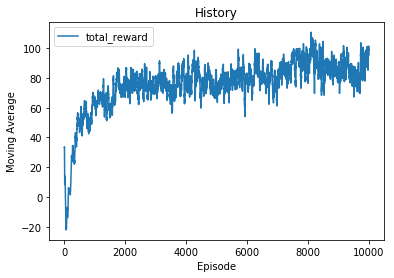

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(history, title, avg_span=30):
    fig1, ax1 = plt.subplots()
    x = range(len(history))
    cumsum = np.cumsum(history)
    avgs = [cumsum[ep]/(ep+1) if ep<avg_span else (cumsum[ep]-cumsum[ep-avg_span])/avg_span for ep in x]
    ax1.plot(x, avgs, label=title)
    ax1.set_title("History")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Moving Average")
    ax1.legend()

plot(history, 'total_reward')